In [1]:
# Imports
import random
import numpy as np
import time as t

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import time as time

from torch import autograd

import model
from keijzer_exogan import *

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 64 # 2**11
image_size = 32
nz = 100 # size of latent vector
num_epochs = 10*10**3
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%
lr = 1e-4
beta1 = 0.5
beta2 = 0.9

lambda_ = 10

beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [2,3] # Number of GPUs available. Use 0 for CPU mode.

path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...
images = np.load(path+'first_chunks_25_percent_images.npy')

swap_labels_randomly = False

train_d_g_conditional = False # switch between training D and G based on set threshold
d_g_conditional_threshold = 0.55 # D_G_z1 < threshold, train G

train_d_g_conditional_per_epoch = False

train_d_g_conditional_per_n_iters = False
train_d_g_n_iters = 2 # When 2, train D 2 times before training G 1 time

use_saved_weights = True

In [3]:
print('Batch size: ', batch_size)
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:int(len(images)*0.1)] # use only first ... percent of the data (0.05)
print('Number of images: ', len(images))

dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)


"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models
netG = model.Generator(ngpu).to(device)
netD = model.Discriminator(ngpu).to(device)

# Apply weights

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init) # It's not clean/efficient to load these ones first, but it works.
netD.apply(weights_init)

if use_saved_weights:
    try:
        # Load saved weights
        netG.load_state_dict(torch.load('netG_state_dict2', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
        netD.load_state_dict(torch.load('netD_state_dict2', map_location=device))
        print('Succesfully loaded saved weights.')
    except:
        print('Could not load saved weights, using new ones.')
        pass

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, device_ids=selected_gpus, output_device=device)
    netD = nn.DataParallel(netD, device_ids=selected_gpus, output_device=device)

Batch size:  64
Number of GPUs used:  2
Number of images:  125000
Succesfully loaded saved weights.


In [4]:
"""
Define input training stuff (fancy this up)
"""
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

switch = True # condition switch, to switch between D and G per epoch
previous_switch = 0

train_D = True
train_G = True

In [ ]:
def calc_gradient_penalty(netD, real_data, fake_data, b_size):
    """
    Source: https://github.com/jalola/improved-wgan-pytorch/blob/master/gan_train.py
    """
    alpha = torch.rand(b_size, 1)
    alpha = alpha.expand(b_size, int(real_data.nelement()/b_size)).contiguous()
    alpha = alpha.view(b_size, 1, image_size, image_size)
    alpha = alpha.to(device)
    
    fake_data = fake_data.view(b_size, 1, image_size, image_size)
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

Switched to WGAN-GP (https://arxiv.org/pdf/1704.00028) instead of DCGAN for training stability reasons.  
Wheras DCGAN collapsed (D(x) staying 0.8-0.9 and D(G(z)) becoming 0.5000) to output black images, WGAN-GP keeps training well.

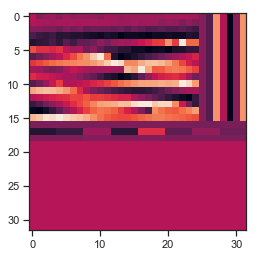

[0/10000][0/1954] G loss: -0.561 	 D loss: -0.032 	 D(x) = 0.708 	 D(G(z)) = 0.552 	 grad_pen = 0.124 	 t = 3.963 	


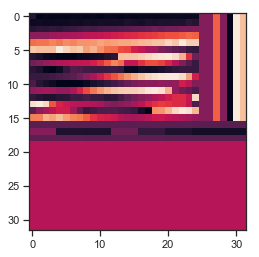

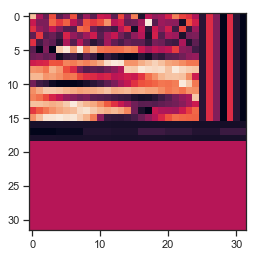

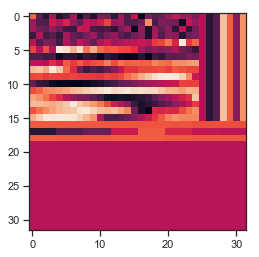

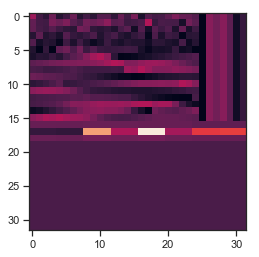

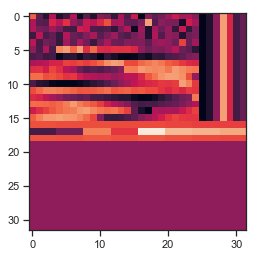

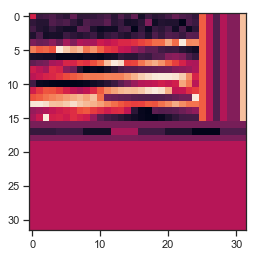

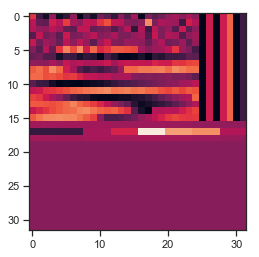

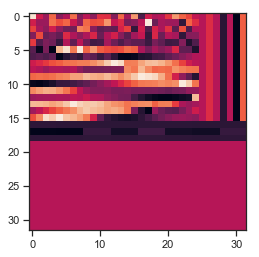

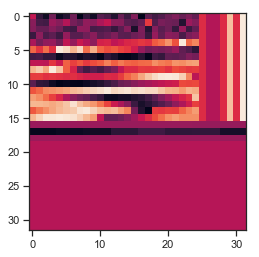

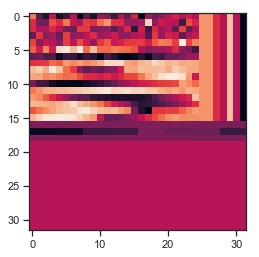

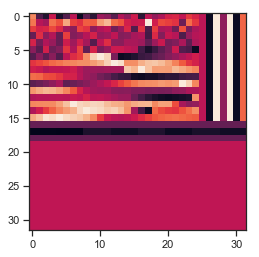

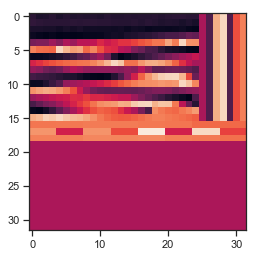

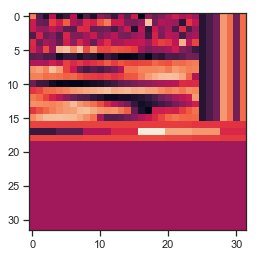

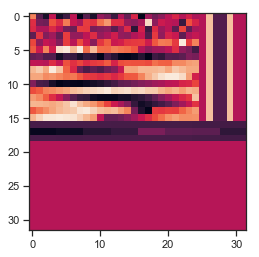

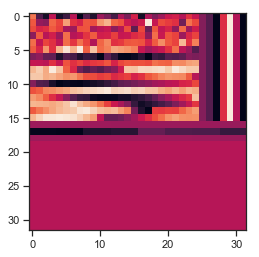

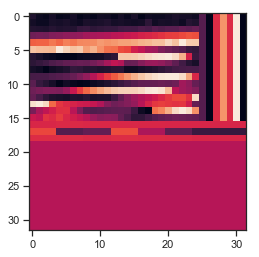

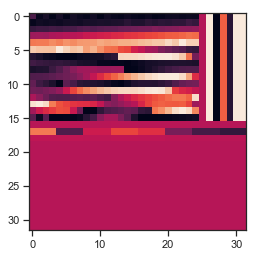

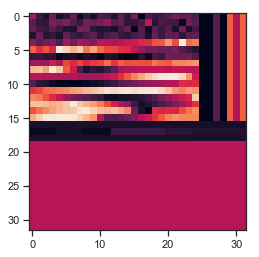

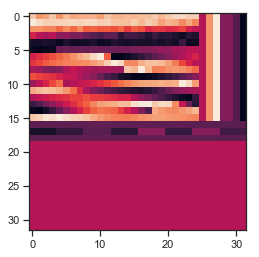

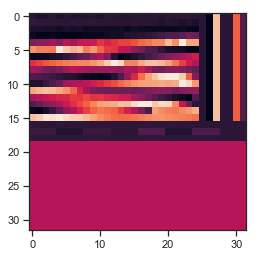

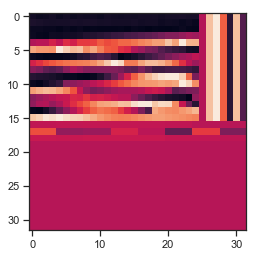

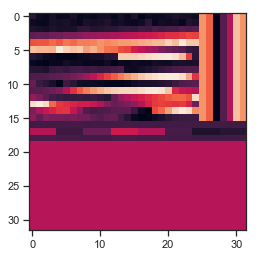

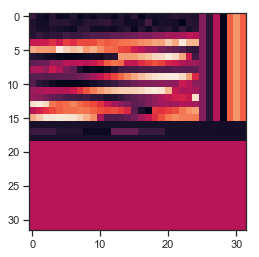

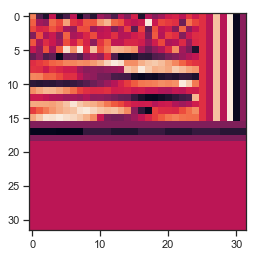

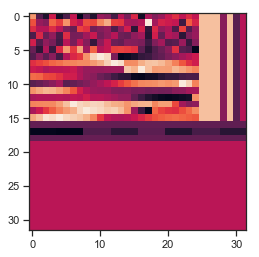

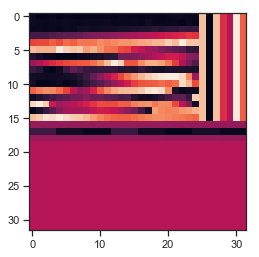

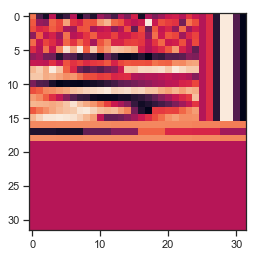

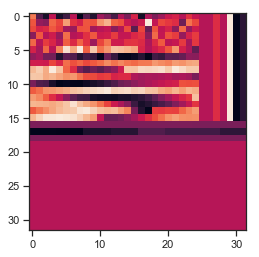

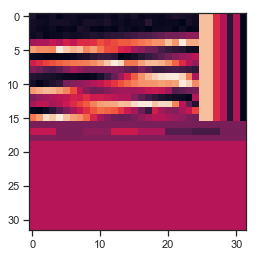

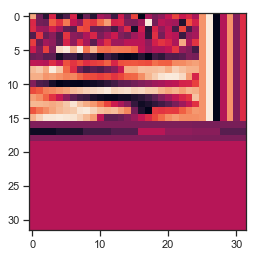

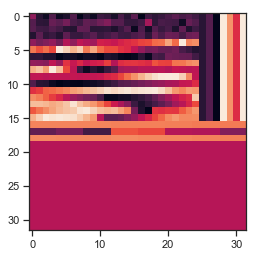

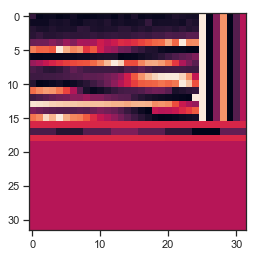

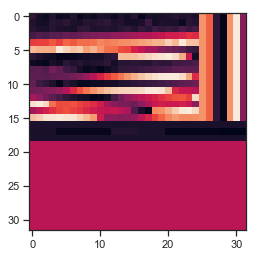

In [ ]:
"""
Highly adapted from: https://github.com/jalola/improved-wgan-pytorch/blob/master/gan_train.py
"""

g_iters = 5 # 5
d_iters = 1 # 1, discriminator is called critic in WGAN paper

one = torch.FloatTensor([1]).to(device)
mone = one * -1

iters = 0
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        real = data.to(device)
        b_size = real.size(0)
        
        """
        Train G
        """
        for p in netD.parameters():
            p.requires_grad_(False)

        for _ in range(g_iters):
            netG.zero_grad()
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            noise.requires_grad_(True)
            fake = netG(noise)

            g_cost = netD(fake).mean()
            g_cost.backward(mone)
            g_cost = -g_cost

        optimizerG.step()

        """
        Train D
        """
        for p in netD.parameters():
            p.requires_grad_(True)

        for _ in range(d_iters):
            netD.zero_grad()

            # generate fake data
            noise = torch.randn(b_size, nz, 1, 1, device=device)

            with torch.no_grad():
                noisev = noise # Freeze G, training D

            fake = netG(noisev).detach()

            # train with real data
            d_real = netD(real).mean()

            # train with fake data
            d_fake = netD(fake).mean()

            # train with interpolates data
            gradient_penalty = calc_gradient_penalty(netD, real, fake, b_size)

             # final disc cost
            d_cost = d_fake - d_real + gradient_penalty
            d_cost.backward()
            w_dist = d_fake  - d_real # wasserstein distance
            optimizerD.step()
            
        
        
        
        weights_saved = False
        if (iters % 100 == 0): # save weights every % .... iters
            #print('weights saved')
            if ngpu > 1:
                torch.save(netG.module.state_dict(), 'netG_state_dict0')
                torch.save(netD.module.state_dict(), 'netD_state_dict0')
            else:
                torch.save(netG.state_dict(), 'netG_state_dict0')
                torch.save(netD.state_dict(), 'netD_state_dict0')
            
        
        if i % (256) == 0:
            t2 = time.time()
            print('[%d/%d][%d/%d] G loss: %.3f \t D loss: %.3f \t D(x) = %.3f \t D(G(z)) = %.3f \t grad_pen = %.3f \t t = %.3f \t'% 
                      (epoch, num_epochs, i, len(dataloader), g_cost, d_cost, d_real, d_fake, gradient_penalty, (t2-t1)))
            t1 = time.time()
                
        iters += i